### XGBoost
- https://xgboost.readthedocs.io/en/latest/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=api#module-xgboost.sklearn

- https://www.lfd.uci.edu/~gohlke/pythonlibs/

In [1]:
%pylab inline

import os, glob, sys, time, datetime
import pandas as pd
import pandas.io.sql as pdsql
from pandas import DataFrame, Series
import math
import numpy as np
from numpy import NaN, Inf, arange, isscalar, asarray, array
import scipy as sp
from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import dates
import matplotlib.font_manager as font_manager
import seaborn as sns

#맑은고딕체
sns.set(style="whitegrid", font="Malgun Gothic", font_scale=1.5)
matplotlib.rcParams['figure.figsize'] = [20, 10]
fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\malgun.TTF", size=15)

#나눔고딕체
# sns.set(style="whitegrid", font="NanumGothic", font_scale=1.5)
# matplotlib.rcParams['figure.figsize'] = [20, 10]
# fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\NanumGothic.TTF", size=15)

#새굴림체
# sns.set(style="whitegrid", font="New Gulim", font_scale=1.5)
# matplotlib.rcParams['figure.figsize'] = [20, 10]
# fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\NGULIM.TTF", size=15)

def comma_volume(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}K'.format(int(x/1000)) #1,000,000,000 이런식으로 나타내주는 포맷
    return s

def comma_price(x, pos):  # formatter function takes tick label and tick position
    s = '{:0,d}'.format(int(x))
    return s

def comma_percent(x, pos):  # formatter function takes tick label and tick position
    s = '{:+.2f}'.format(x) #부호 붙혀주고 소수점 2자리까지 반올림 처리
    return s

major_date_formatter = dates.DateFormatter('%Y-%m-%d')
minor_date_formatter = dates.DateFormatter('%m')
price_formatter = ticker.FuncFormatter(comma_price)
volume_formatter = ticker.FuncFormatter(comma_volume)
percent_formatter = ticker.FuncFormatter(comma_percent)

sns.set(style="whitegrid", font="Malgun Gothic", font_scale=1.5)
matplotlib.rcParams['figure.figsize'] = [20, 10]
fp = font_manager.FontProperties(fname="C:\\WINDOWS\\Fonts\\malgun.TTF", size=15)

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, XGBModel
from xgboost import plot_importance, plot_tree

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def XGBoost_Feature(model, df, X_columns, y_columns, performCV=True, printFeatureImportance=True, cv_folds=5):
    print(model)

    model.fit(df[X_columns], df[y_columns])
        
    df_predictions = model.predict(df[X_columns])
    try:
        df_predprob = model.predict_proba(df[X_columns])[:,1]
    except Exception as e:
        pass

    print ("\n모델 보고서")
    try:
        print ("정확도(Accuracy) : %.4g" % metrics.accuracy_score(df[y_columns].values, df_predictions))
    except Exception as e:
        pass
#https://blog.naver.com/happyrachy/221296365817 참고 AUC가 무엇인가
    try:
        print ("AUC 점수 (Train): %f" % metrics.roc_auc_score(df[y_columns].values, df_predprob))
    except Exception as e:
        pass

    if performCV:
        try:
            cv_score = cross_validation.cross_val_score(model, df[X_columns], df[y_columns], cv=cv_folds, scoring='roc_auc')
            print ("교차검증(CV) 점수 : 평균 - %.7g | 표준편차 - %.7g | 최소값 - %.7g | 최대값 - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        except Exception as e:
            pass
        
    try:
        if printFeatureImportance:
            fig, ax = plt.subplots(1, 1, sharex=True)
            feat_imp = pd.Series(model.feature_importances_, X_columns).sort_values(ascending=False)
            feat_imp.plot(ax=ax, kind='bar', title='특성(Feature) 중요도')
            ax.yaxis.set_major_formatter(percent_formatter)
            plt.ylabel('특성(Feature) 중요도 점수')
            plt.savefig('특성(Feature) 중요도.png')
            plt.show()
    except Exception as e:
        pass

def XGBoost_TrainingPerformance(model, X, y, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) #동일분포 내에서 train test 나눔

    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=verbose)

    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions) #accuracy_score 함수
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.yaxis.set_major_formatter(percent_formatter)
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.yaxis.set_major_formatter(percent_formatter)
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()

def XGBoost_EarlyStop(model, X, y, early_stopping_rounds=10, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
    eval_set = [(X_test, y_test)]
    model.fit(X_train, y_train, early_stopping_rounds=early_stopping_rounds, eval_metric="logloss", eval_set=eval_set, verbose=verbose)

    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

def XGBoost_NumberOfThreads(X, y, num_threads=[1, 2, 3, 4,5,6,7,8]):
    results = []
    for n in num_threads:
        start = time.time()
        model = XGBClassifier(nthread=n)
        model.fit(X, y)
        elapsed = time.time() - start
        print(n, elapsed)
        results.append(elapsed)

    plt.plot(num_threads, results)
    plt.ylabel('Speed (seconds)')
    plt.xlabel('Number of Threads')
    plt.title('XGBoost Training Speed vs Number of Threads')
    plt.show()

def XGBoost_NumberOfTree(model, X, y, n_estimators):
    param_grid = dict(n_estimators=n_estimators)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    
    fig, ax = plt.subplots()
    plt.errorbar(n_estimators, means, yerr=stds)
    ax.yaxis.set_major_formatter(percent_formatter)
    plt.title("XGBoost n_estimators vs Log Loss")
    plt.xlabel('n_estimators')
    plt.ylabel('Log Loss')
    plt.show()

def XGBoost_SizeOfTree(model, X, y, max_depth):
    print(max_depth)
    param_grid = dict(max_depth=max_depth)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    fig, ax = plt.subplots()
    plt.errorbar(max_depth, means, yerr=stds)
    ax.yaxis.set_major_formatter(percent_formatter)
    plt.title("XGBoost max_depth vs Log Loss")
    plt.xlabel('max_depth')
    plt.ylabel('Log Loss')
    plt.show()

def XGBoost_NumberAndSizeOfTree(model, X, y, n_estimators, max_depth):
    print(max_depth)
    param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    scores = np.array(means).reshape(len(max_depth), len(n_estimators))
    fig, ax = plt.subplots()
    for i, value in enumerate(max_depth):
        plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
    ax.yaxis.set_major_formatter(percent_formatter)
    plt.legend()
    plt.xlabel('n_estimators')
    plt.ylabel('Log Loss')
    plt.show()

def XGBoost_LearningRate(model, X, y, learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]):
    param_grid = dict(learning_rate=learning_rate)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    fig, ax = plt.subplots()
    plt.errorbar(learning_rate, means, yerr=stds)
    ax.yaxis.set_major_formatter(percent_formatter)
    plt.title("XGBoost learning_rate vs Log Loss")
    plt.xlabel('learning_rate')
    plt.ylabel('Log Loss')
    plt.show()
    
def XGBoost_LearningRateAndNumberOfTree(model, X, y, n_estimators, learning_rate):
    param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
    fig, ax = plt.subplots()
    for i, value in enumerate(learning_rate):
        plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
    ax.yaxis.set_major_formatter(percent_formatter)
    plt.legend()
    plt.xlabel('n_estimators')    
    plt.ylabel('Log Loss')
    plt.show()

def XGBoost_SubSamples(model, X, y, subsample=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]):
    param_grid = dict(subsample=subsample)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    fig, ax = plt.subplots()
    plt.errorbar(subsample, means, yerr=stds)
    ax.yaxis.set_major_formatter(percent_formatter)
    plt.title("XGBoost subsample vs Log Loss")
    plt.xlabel('subsample')
    plt.ylabel('Log Loss')
    plt.show()

def XGBoost_ColumnSubSamples(model, X, y, colsample_bytree=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]):
    param_grid = dict(colsample_bytree=colsample_bytree)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    fig, ax = plt.subplots()
    plt.errorbar(colsample_bytree, means, yerr=stds)
    ax.yaxis.set_major_formatter(percent_formatter)
    plt.title("XGBoost colsample_bytree vs Log Loss")
    plt.xlabel('colsample_bytree')
    plt.ylabel('Log Loss')
    plt.show()

def XGBoost_ColumnSubSamplesBySplit(model, X, y, colsample_bylevel=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]):
    param_grid = dict(colsample_bylevel=colsample_bylevel)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    fig, ax = plt.subplots()
    plt.errorbar(colsample_bylevel, means, yerr=stds)
    ax.yaxis.set_major_formatter(percent_formatter)
    plt.title("XGBoost colsample_bylevel vs Log Loss")
    plt.xlabel('colsample_bylevel')
    plt.ylabel('Log Loss')
    plt.show()
    
def XGBoost_TuningTest(model, X, y, param_grid=None):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, y)

    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [5]:
# CSV로 저장되어 있는 증권사 HTS 주가 자료는 시간 역순이라, 이것을 바로잡는다.
path = 'C:/Users/USER/Desktop/haley/TAVE/캐글_스터디/'
df = pd.read_csv(path+'KODEX200.csv', encoding='cp949',engine='python')
df.tail()
df = df.reindex(index=df.index[::-1])
df.reset_index(inplace=True)
df.set_index('일시', inplace=True)
df.drop(['index'], axis=1, inplace=True)

df.tail()

,시가,고가,저가,종가
일시,,,,
2018-07-11,29515,29635,29280,29560
2018-07-12,29615,29800,29500,29650
2018-07-13,29695,30040,29685,29945
2018-07-16,29975,30050,29825,29855
2018-07-17,29860,29925,29680,29820


In [6]:
X_COLUMNS = []

for i in range(1,6):
    df['P%d' % i] = df['종가'].shift(i)
    X_COLUMNS.append('P%d' % i)
# df

In [7]:
# df['수익률'] = (df['고가'].shift(-1) - df['시가'].shift(-1)) / df['시가'].shift(-1)
df['수익률'] = (df['종가'].shift(-1) - df['시가'].shift(-1)) / df['시가'].shift(-1)
df['y'] = df['수익률'].apply(lambda x: 1 if x > 0.003 else 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True) #무한대 값이나 결측값일 경우 drop 시킨다
df.dropna(inplace=True)
#df.head()
#df['종가'].shift(-1).head()
#df['수익률'].head()
df.tail()

,시가,고가,저가,종가,P1,P2,P3,P4,P5,수익률,y
일시,,,,,,,,,,,
2018-07-10,29810,29905,29710,29730,29690.0,29470.0,29260.0,29330.0,29415.0,0.001525,0
2018-07-11,29515,29635,29280,29560,29730.0,29690.0,29470.0,29260.0,29330.0,0.001182,0
2018-07-12,29615,29800,29500,29650,29560.0,29730.0,29690.0,29470.0,29260.0,0.008419,1
2018-07-13,29695,30040,29685,29945,29650.0,29560.0,29730.0,29690.0,29470.0,-0.004003,0
2018-07-16,29975,30050,29825,29855,29945.0,29650.0,29560.0,29730.0,29690.0,-0.001340,0


In [8]:
X_COLUMNS

['P1', 'P2', 'P3', 'P4', 'P5']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

모델 보고서


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


정확도(Accuracy) : 0.6722
AUC 점수 (Train): 0.720084


교차검증(CV) 점수 : 평균 - 0.4492044 | 표준편차 - 0.1093873 | 최소값 - 0.318551 | 최대값 - 0.6094675


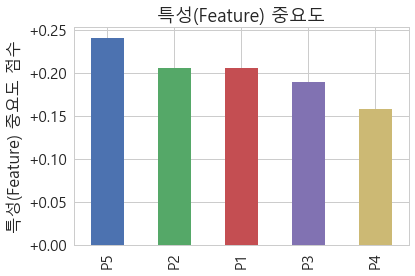

In [9]:
X = df[X_COLUMNS].values.tolist()
y = df['y'].values.tolist()

default_params = {'random_state': 0}
model = XGBClassifier(**default_params)

XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)


Accuracy: 63.97%


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


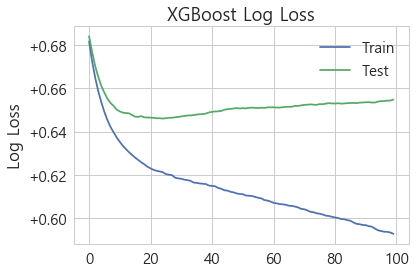

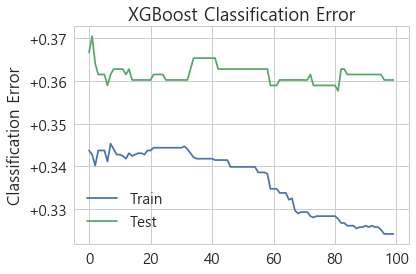

In [10]:
XGBoost_TrainingPerformance(model, X=np.array(X), y=np.array(y), verbose=False)

In [11]:
XGBoost_EarlyStop(model, X=np.array(X), y=np.array(y), early_stopping_rounds=10, verbose=True)

[0]	validation_0-logloss:0.684168


Will train until validation_0-logloss hasn't improved in 10 rounds.


[1]	validation_0-logloss:0.676951


[2]	validation_0-logloss:0.670369


[3]	validation_0-logloss:0.665327


[4]	validation_0-logloss:0.661149


[5]	validation_0-logloss:0.657972


[6]	validation_0-logloss:0.655212


[7]	validation_0-logloss:0.653226


[8]	validation_0-logloss:0.651948


[9]	validation_0-logloss:0.650188


[10]	validation_0-logloss:0.649381


[11]	validation_0-logloss:0.648794


[12]	validation_0-logloss:0.648616


[13]	validation_0-logloss:0.648483


[14]	validation_0-logloss:0.6477


[15]	validation_0-logloss:0.646917


[16]	validation_0-logloss:0.646853


[17]	validation_0-logloss:0.647189


[18]	validation_0-logloss:0.646604


[19]	validation_0-logloss:0.646562


[20]	validation_0-logloss:0.64648


[21]	validation_0-logloss:0.646406


[22]	validation_0-logloss:0.646199


[23]	validation_0-logloss:0.646201


[24]	validation_0-logloss:0.64607


[25]	validation_0-logloss:0.646225


[26]	validation_0-logloss:0.6464


[27]	validation_0-logloss:0.646462


[28]	validation_0-logloss:0.646646


[29]	validation_0-logloss:0.646814


[30]	validation_0-logloss:0.647047


[31]	validation_0-logloss:0.647238


[32]	validation_0-logloss:0.647476


[33]	validation_0-logloss:0.647516


[34]	validation_0-logloss:0.647682


Stopping. Best iteration:
[24]	validation_0-logloss:0.64607



Accuracy: 63.46%


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1 0.17756223678588867
2 0.16751456260681152


3 0.16356205940246582


4 0.22739171981811523


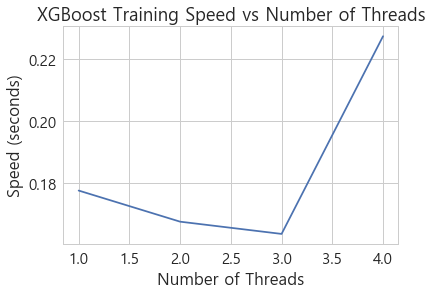

In [12]:
XGBoost_NumberOfThreads(X=np.array(X), y=np.array(y), num_threads=[1, 2, 3, 4])

Best: -0.642855 using {'n_estimators': 30}
-0.647966 (0.003352) with: {'n_estimators': 10}
-0.643107 (0.005521) with: {'n_estimators': 20}
-0.642855 (0.006248) with: {'n_estimators': 30}
-0.644092 (0.006185) with: {'n_estimators': 40}


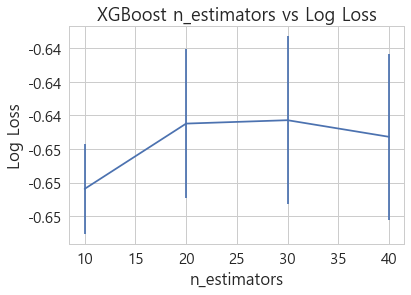

In [13]:
n_estimators = range(10, 50, 10)
XGBoost_NumberOfTree(model, np.array(X), np.array(y), n_estimators=n_estimators)

range(1, 7, 2)
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.8s finished


Best: -0.641402 using {'max_depth': 1}
-0.641402 (0.005330) with: {'max_depth': 1}
-0.650291 (0.007089) with: {'max_depth': 3}
-0.659773 (0.008429) with: {'max_depth': 5}


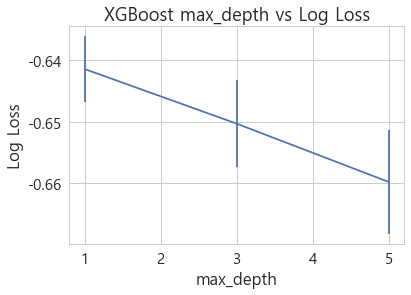

In [14]:
max_depth = range(1, 7, 2)
XGBoost_SizeOfTree(model, X=np.array(X), y=np.array(y), max_depth=max_depth)

range(1, 7, 2)
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    5.7s remaining:    1.8s


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    6.0s finished


Best: -0.639972 using {'max_depth': 1, 'n_estimators': 30}
-0.646390 (0.002656) with: {'max_depth': 1, 'n_estimators': 10}
-0.640296 (0.004309) with: {'max_depth': 1, 'n_estimators': 20}
-0.639972 (0.004898) with: {'max_depth': 1, 'n_estimators': 30}
-0.640317 (0.005128) with: {'max_depth': 1, 'n_estimators': 40}
-0.647966 (0.003352) with: {'max_depth': 3, 'n_estimators': 10}
-0.643107 (0.005521) with: {'max_depth': 3, 'n_estimators': 20}
-0.642855 (0.006248) with: {'max_depth': 3, 'n_estimators': 30}
-0.644092 (0.006185) with: {'max_depth': 3, 'n_estimators': 40}
-0.649190 (0.003179) with: {'max_depth': 5, 'n_estimators': 10}
-0.644974 (0.004201) with: {'max_depth': 5, 'n_estimators': 20}
-0.646487 (0.005429) with: {'max_depth': 5, 'n_estimators': 30}
-0.648288 (0.005953) with: {'max_depth': 5, 'n_estimators': 40}


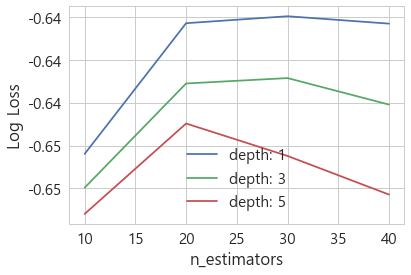

In [15]:
XGBoost_NumberAndSizeOfTree(model, X=np.array(X), y=np.array(y), n_estimators=n_estimators, max_depth=max_depth)

Best: -0.648488 using {'learning_rate': 0.01}
-0.692114 (0.000064) with: {'learning_rate': 0.0001}
-0.683750 (0.000524) with: {'learning_rate': 0.001}
-0.648488 (0.003161) with: {'learning_rate': 0.01}
-0.650291 (0.007089) with: {'learning_rate': 0.1}
-0.662662 (0.006710) with: {'learning_rate': 0.2}
-0.673204 (0.007165) with: {'learning_rate': 0.3}


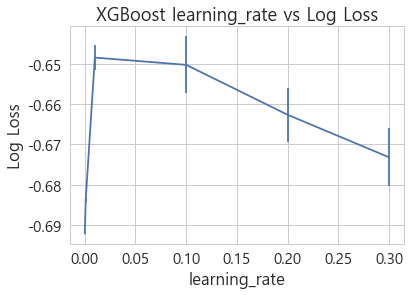

In [16]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
XGBoost_LearningRate(model, X=np.array(X), y=np.array(y), learning_rate=learning_rate)

Best: -0.642855 using {'learning_rate': 0.1, 'n_estimators': 30}
-0.693043 (0.000007) with: {'learning_rate': 0.0001, 'n_estimators': 10}
-0.692939 (0.000013) with: {'learning_rate': 0.0001, 'n_estimators': 20}
-0.692836 (0.000020) with: {'learning_rate': 0.0001, 'n_estimators': 30}
-0.692732 (0.000026) with: {'learning_rate': 0.0001, 'n_estimators': 40}
-0.692114 (0.000063) with: {'learning_rate': 0.001, 'n_estimators': 10}
-0.691104 (0.000114) with: {'learning_rate': 0.001, 'n_estimators': 20}
-0.690116 (0.000166) with: {'learning_rate': 0.001, 'n_estimators': 30}
-0.689150 (0.000221) with: {'learning_rate': 0.001, 'n_estimators': 40}
-0.683717 (0.000531) with: {'learning_rate': 0.01, 'n_estimators': 10}
-0.676013 (0.000919) with: {'learning_rate': 0.01, 'n_estimators': 20}
-0.669688 (0.001301) with: {'learning_rate': 0.01, 'n_estimators': 30}
-0.664562 (0.001615) with: {'learning_rate': 0.01, 'n_estimators': 40}
-0.647966 (0.003352) with: {'learning_rate': 0.1, 'n_estimators': 10}
-

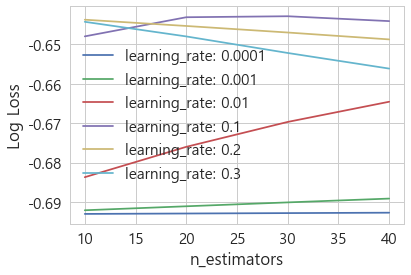

In [17]:
XGBoost_LearningRateAndNumberOfTree(model, X=np.array(X), y=np.array(y), n_estimators=n_estimators, learning_rate=learning_rate)

Best: -0.650291 using {'subsample': 1.0}
-0.653743 (0.010991) with: {'subsample': 0.1}
-0.655392 (0.009833) with: {'subsample': 0.2}
-0.654115 (0.008165) with: {'subsample': 0.3}
-0.656351 (0.008190) with: {'subsample': 0.4}
-0.651712 (0.006597) with: {'subsample': 0.5}
-0.653171 (0.007355) with: {'subsample': 0.6}
-0.650956 (0.006529) with: {'subsample': 0.7}
-0.651367 (0.006764) with: {'subsample': 0.8}
-0.650291 (0.007089) with: {'subsample': 1.0}


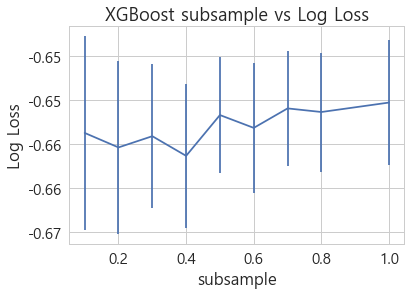

In [18]:
subsample=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
XGBoost_SubSamples(model, X=np.array(X), y=np.array(y), subsample=subsample)

Best: -0.648093 using {'colsample_bytree': 0.1}
-0.648093 (0.005934) with: {'colsample_bytree': 0.1}
-0.648093 (0.005934) with: {'colsample_bytree': 0.2}
-0.648093 (0.005934) with: {'colsample_bytree': 0.3}
-0.650404 (0.007781) with: {'colsample_bytree': 0.4}
-0.650404 (0.007781) with: {'colsample_bytree': 0.5}
-0.649515 (0.008057) with: {'colsample_bytree': 0.6}
-0.649515 (0.008057) with: {'colsample_bytree': 0.7}
-0.650347 (0.007093) with: {'colsample_bytree': 0.8}
-0.650291 (0.007089) with: {'colsample_bytree': 1.0}


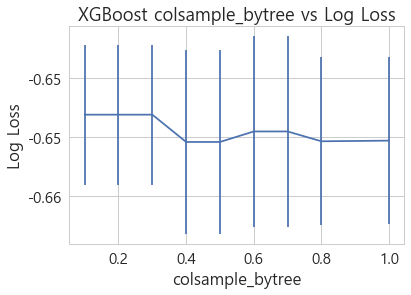

In [19]:
colsample_bytree=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
XGBoost_ColumnSubSamples(model, X=np.array(X), y=np.array(y), colsample_bytree=colsample_bytree)

Best: -0.648516 using {'colsample_bylevel': 0.1}
-0.648516 (0.006136) with: {'colsample_bylevel': 0.1}
-0.648516 (0.006136) with: {'colsample_bylevel': 0.2}
-0.648516 (0.006136) with: {'colsample_bylevel': 0.3}
-0.649535 (0.006669) with: {'colsample_bylevel': 0.4}
-0.649535 (0.006669) with: {'colsample_bylevel': 0.5}
-0.649849 (0.006851) with: {'colsample_bylevel': 0.6}
-0.649849 (0.006851) with: {'colsample_bylevel': 0.7}
-0.649346 (0.006688) with: {'colsample_bylevel': 0.8}
-0.650291 (0.007089) with: {'colsample_bylevel': 1.0}


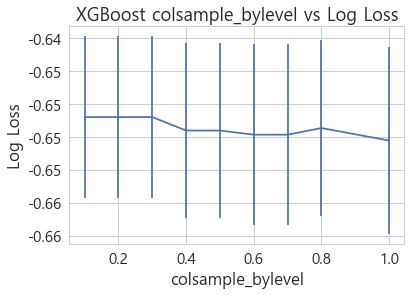

In [20]:
colsample_bylevel=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
XGBoost_ColumnSubSamplesBySplit(model, X=np.array(X), y=np.array(y), colsample_bylevel=colsample_bylevel)

In [22]:
param_grid = {
    'max_depth': range(1, 4, 1),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1], 
    'n_estimators': range(10, 50, 10),
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'colsample_bylevel':[0.8, 1.0]
}

XGBoost_TuningTest(model, X=np.array(X), y=np.array(y), param_grid=param_grid)

Best: -0.639650 using {'colsample_bylevel': 0.8, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 30, 'subsample': 0.8}
-0.693043 (0.000003) with: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 10, 'subsample': 0.8}
-0.693042 (0.000003) with: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 10, 'subsample': 1.0}
-0.692938 (0.000006) with: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 20, 'subsample': 0.8}
-0.692937 (0.000005) with: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 20, 'subsample': 1.0}
-0.692833 (0.000009) with: {'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.0001, 'max_depth': 1, 'n_estimators': 30, 'subsample': 0.8}
-0.692833 (0.000008) with: {'colsample_bylevel': 0.8, 'colsa

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

모델 보고서
정확도(Accuracy) : 0.6499
AUC 점수 (Train): 0.588770
교차검증(CV) 점수 : 평균 - 0.45979 | 표준편차 - 0.1245317 | 최소값 - 0.2988895 | 최대값 - 0.6153846


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


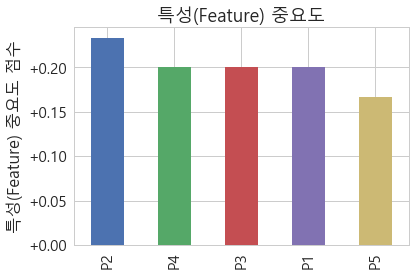

In [23]:
tuned_params = {'subsample': 0.8, 'learning_rate': 0.1, 'n_estimators': 30, 'colsample_bylevel': 1.0, 'max_depth': 1, 'colsample_bytree': 0.8,'random_state': 0}
model = XGBClassifier(**tuned_params)
XGBoost_Feature(model=model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=nan, n_estimators=30,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

모델 보고서
정확도(Accuracy) : 0.6499
AUC 점수 (Train): 0.588770
교차검증(CV) 점수 : 평균 - 0.45979 | 표준편차 - 0.1245317 | 최소값 - 0.2988895 | 최대값 - 0.6153846


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


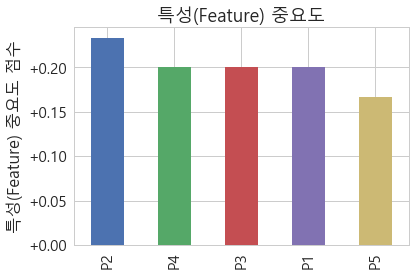

In [24]:
import pickle

pickle.dump(model, open("TEST.xgb", "wb"))
saved_model = pickle.load(open("TEST.xgb", "rb"))

XGBoost_Feature(model=saved_model, df=df, X_columns=X_COLUMNS, y_columns='y', performCV=True, printFeatureImportance=True, cv_folds=5)

Accuracy: 63.85%


C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


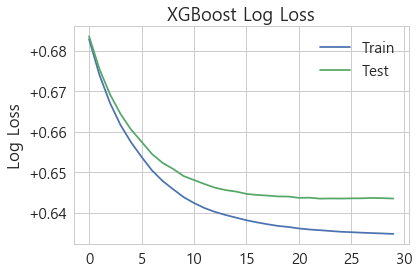

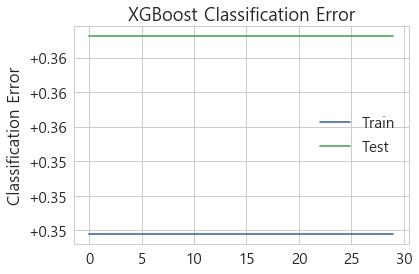

In [25]:
XGBoost_TrainingPerformance(saved_model, X=np.array(X), y=np.array(y))